# Model Linearity

## General definition

The model linearity module in alibi aims to provide a metric to measure how linear is a ML model. Linearity is defined based on how much the linear superposition of the model's outputs differs from the output of the same linear superposition of the inputs. 

Given $N$ input vectors $v_i$, $N$ real coefficients $\alpha_i$ and a predict function $\text{M}(v_i)$, the linearity of the predict function is defined as

$$L = \Big|\Big|\sum_i \alpha_i M(v_i) - M\Big(\sum_i \alpha_i v_i\Big) \Big|\Big| \quad \quad \text{If M is a regressor}$$

$$L = \Big|\Big|\sum_i \alpha_i \log \circ M(v_i) - \log \circ M\Big(\sum_i \alpha_i v_i\Big)\Big|\Big| \quad \quad \text{If M is a classifier}$$

## Alibi implementation
* Based on the general definition above, alibi calculates the linearity of a model in the neighboorhood of a given instance $v_0$. 

* As an example, we will visualize the decision boundaries and the values of the linearity measure for various classifier on the iris dataset. Only 2 features are included for visualization porpuses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from itertools import product
from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure

## Dataset

In [2]:
ds = load_iris()
X_train, y_train = ds.data[:, :2], ds.target

In [3]:
lins_dict = {}

## Models
We will experiment with 5 different classifiers:
* A logistic regression model, which is expected to be highly linear.
* A random forest classifier, which is expected to be higly non linear.
* A xgboost classifier.
* A support vector machines classifier.
* A feed forward neural network

In [4]:
lr = LogisticRegression(fit_intercept=False, multi_class='multinomial', solver='newton-cg')
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100)
svm = SVC(gamma=.1, kernel='rbf', probability=True)
nn = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu')

In [5]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
svm.fit(X_train, y_train)
nn.fit(X_train, y_train)

/home/fdz/anaconda3/envs/alibi/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

## Decision boundaries and linearity 

In [6]:
# Creating grid
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [7]:
# Flattening points in the grid
X = np.empty((len(xx.flatten()), 2))
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        k = i * xx.shape[1] + j
        X[k] = np.array([xx[i, j], yy[i, j]])

### Logistic regression

In [8]:
# Defining predict function for logistic regression
clf = lr
predict_fn = lambda x: clf.predict_proba(x)

In [9]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)
lins_dict['LR'] = L.mean()

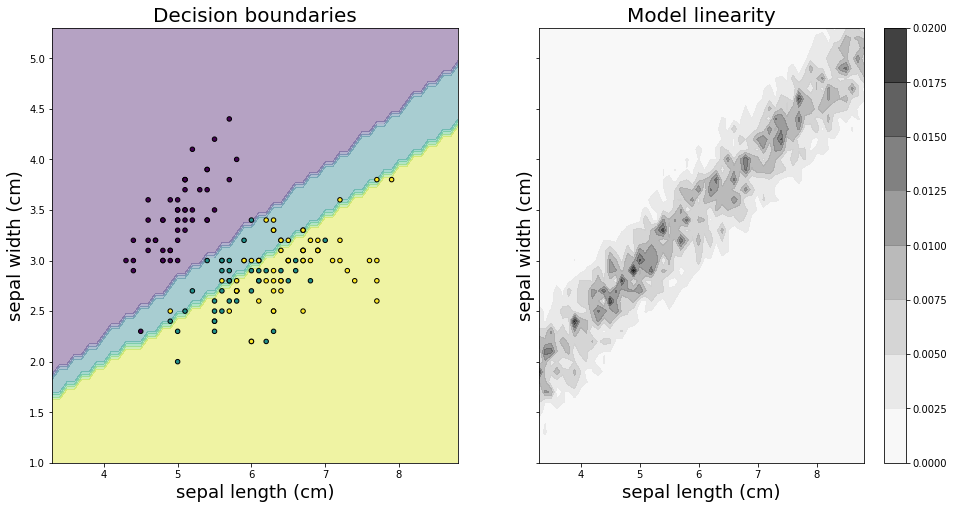

Decision boundaries (left panel) and linearity measure (right panel) for a logistic regression (LG) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.
Maximum value model linearity: 0.01879
Minimum value model linearity: 0.0


In [12]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries', fontsize=20)
axarr[0].set_xlabel('sepal length (cm)',fontsize=18)
axarr[0].set_ylabel('sepal width (cm)', fontsize=18)

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity', fontsize=20)
axarr[1].set_xlabel('sepal length (cm)', fontsize=18)
axarr[1].set_ylabel('sepal width (cm)', fontsize=18)
cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()
print('Decision boundaries (left panel) and linearity measure (right panel) for a logistic regression (LG) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.')
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

### Random forest

In [31]:
# Defining predict function for random forest
clf = rf
predict_fn = lambda x: clf.predict_proba(x)

In [32]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)
lins_dict['RF'] = L.mean()

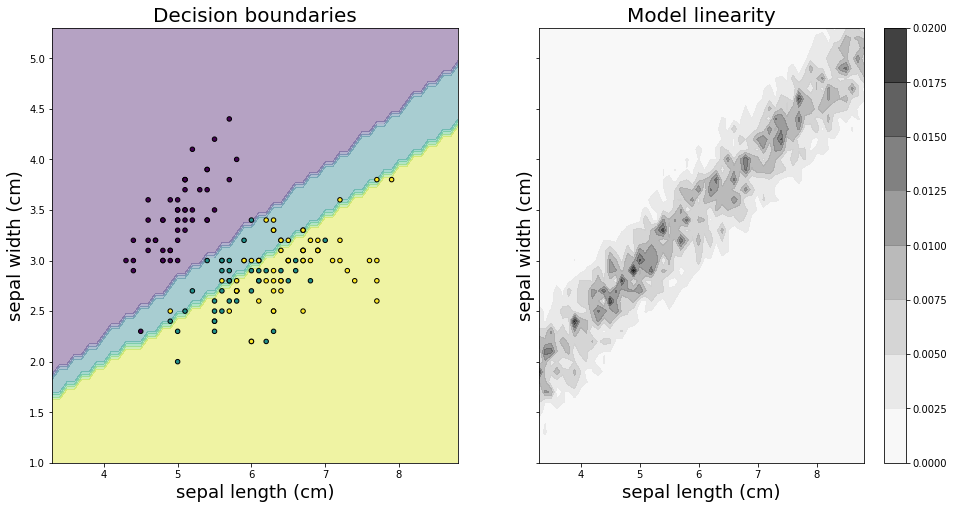

Decision boundaries (left panel) and linearity measure (right panel) for a random forest (RF) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.
Maximum value model linearity: 0.01879
Minimum value model linearity: 0.0


In [13]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries', fontsize=20)
axarr[0].set_xlabel('sepal length (cm)', fontsize=18)
axarr[0].set_ylabel('sepal width (cm)', fontsize=18)

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity', fontsize=20)
axarr[1].set_xlabel('sepal length (cm)', fontsize=18)
axarr[1].set_ylabel('sepal width (cm)', fontsize=18)

cbar = f.colorbar(LPL)
plt.show()
print('Decision boundaries (left panel) and linearity measure (right panel) for a random forest (RF) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.')
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

### Xgboost

In [14]:
# Defining predict function for xgboost
clf = xgb
predict_fn = lambda x: clf.predict_proba(x)

In [15]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)
lins_dict['XB'] = L.mean()

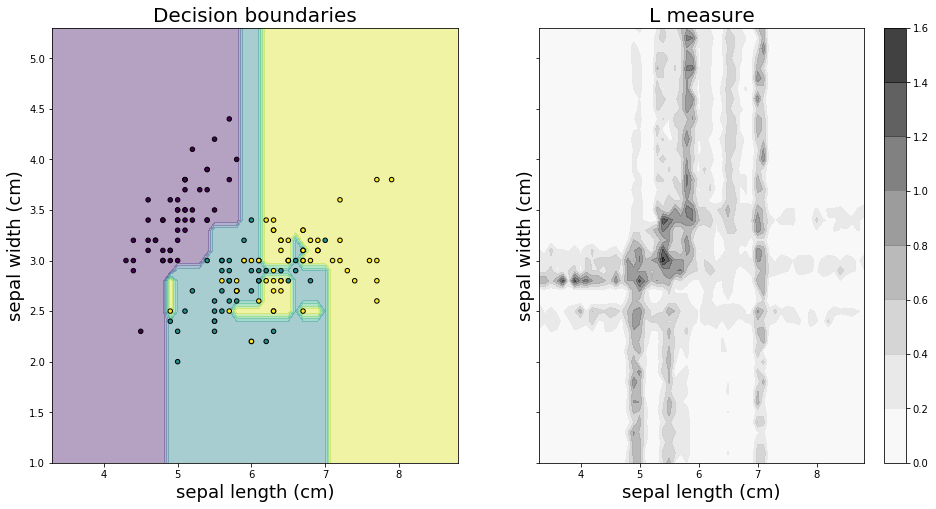

Decision boundaries (left panel) and linearity measure (right panel) for a xgboost (XB) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.
Maximum value model linearity: 1.47275
Minimum value model linearity: 0.0


In [17]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries', fontsize=20)
axarr[0].set_xlabel('sepal length (cm)', fontsize=18)
axarr[0].set_ylabel('sepal width (cm)', fontsize=18)

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('L measure', fontsize=20)
axarr[1].set_xlabel('sepal length (cm)', fontsize=18)
axarr[1].set_ylabel('sepal width (cm)', fontsize=18)

cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()
print('Decision boundaries (left panel) and linearity measure (right panel) for a xgboost (XB) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.')
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

### SVM

In [18]:
# Defining predict function for svm
clf = svm
predict_fn = lambda x: clf.predict_proba(x)

In [19]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)
lins_dict['SM'] = L.mean()

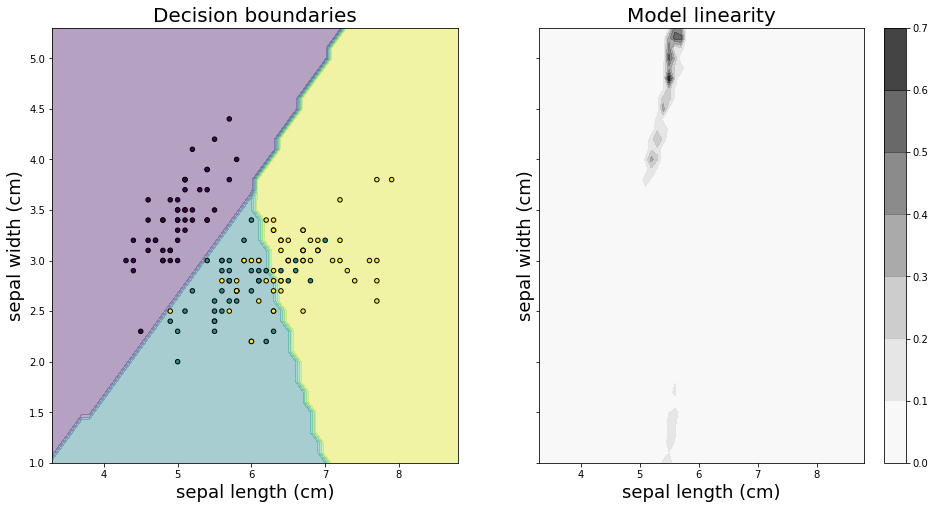

Decision boundaries (left panel) and linearity measure (right panel) for a support vector machine (SM) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.
Maximum value model linearity: 0.68252
Minimum value model linearity: 0.00101


In [20]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries', fontsize=20)
axarr[0].set_xlabel('sepal length (cm)', fontsize=18)
axarr[0].set_ylabel('sepal width (cm)', fontsize=18)

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity', fontsize=20)
axarr[1].set_xlabel('sepal length (cm)', fontsize=18)
axarr[1].set_ylabel('sepal width (cm)', fontsize=18)

cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()
print('Decision boundaries (left panel) and linearity measure (right panel) for a support vector machine (SM) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.')
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

### NN

In [21]:
# Defining predict function for svm
clf = nn
predict_fn = lambda x: clf.predict_proba(x)

In [22]:
# Calculating linearity for all points in the grid
lm = LinearityMeasure(agg='pairwise')
lm.fit(X_train)
L = lm.score(predict_fn, X)
L = L.reshape(xx.shape)
lins_dict['NN'] = L.mean()

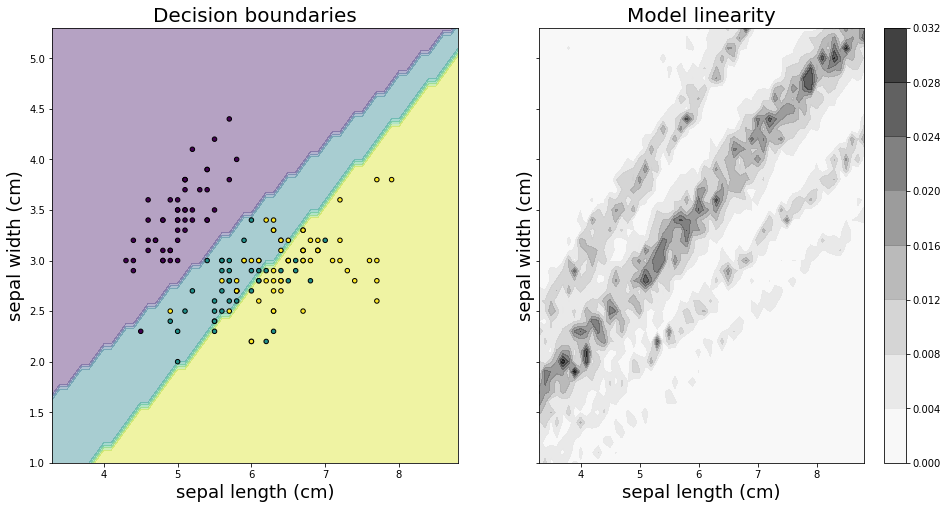

Decision boundaries (left panel) and linearity measure (right panel) for a feed forward neural network classifier (NN) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.
Maximum value model linearity: 0.03074
Minimum value model linearity: 0.0


In [23]:
# Visualising decision boundaries and linearity values 
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 8))
idx = (0,0)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', alpha=1)
axarr[0].set_title('Decision boundaries', fontsize=20)
axarr[0].set_xlabel('sepal length (cm)', fontsize=18)
axarr[0].set_ylabel('sepal width (cm)', fontsize=18)

LPL = axarr[1].contourf(xx, yy, L, alpha=0.8, cmap='Greys')
axarr[1].set_title('Model linearity', fontsize=20)
axarr[1].set_xlabel('sepal length (cm)', fontsize=18)
axarr[1].set_ylabel('sepal width (cm)', fontsize=18)

cbar = f.colorbar(LPL)
#cbar.ax.set_ylabel('Linearity')
plt.show()
print('Decision boundaries (left panel) and linearity measure (right panel) for a feed forward neural network classifier (NN) classifier in features space. The x and y axis in the plots represent the sepal length and the sepal width, respectively.  Different colours correspond to different predicted classes. The markers represents the data points in the training set.')
print('Maximum value model linearity: {}'. format(np.round(L.max(), 5))) 
print('Minimum value model linearity: {}'.format(np.round(L.min(),5)))

## Average linearity over the whole features space

Comparison of the linearity measure $L$ averaged over the whole features space for various models trained on the iris dataset: random forest (RF), xgboost (XB), support vector machine (SM), neural network (NN) and logistic regression (LR). Note that the scale of the X axis is logarithmic.


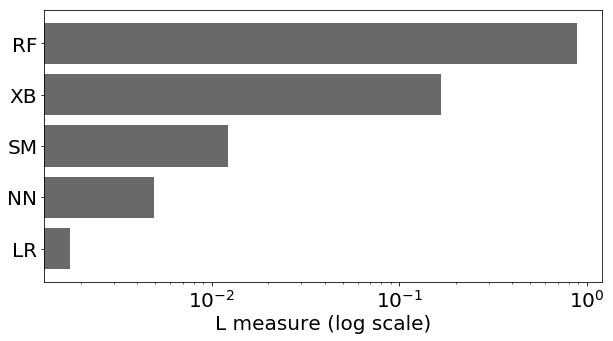

In [43]:
ax = pd.Series(data=lins_dict).sort_values().plot(kind='barh', figsize=(10,5), fontsize=20, color='dimgray', 
                                                  width=0.8, logx=True)
ax.set_xlabel('L measure (log scale)', fontsize=20)
print('Comparison of the linearity measure $L$ averaged over the whole features space for various models trained on the iris dataset: random forest (RF), xgboost (XB), support vector machine (SM), neural network (NN) and logistic regression (LR). Note that the scale of the X axis is logarithmic.')